# Daily Retreat: Using Sentiment Analysis to<br>Find, Personalize, and Share Positive News from Popular Online Sources
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-599-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'July/August 2023'

## Setup

In [2]:
# Are we running in Google Colab, or not?
try:
    from google.colab import drive
    COLAB = True
except:
    COLAB = False

if COLAB:
    # Establish Google Drive connection
    drive.mount('/content/drive', force_remount = True)

    # Establish working directory
    %cd '/content/drive/My Drive/599_team_project/deliverables'

Mounted at /content/drive
/content/drive/My Drive/599_team_project/deliverables


In [3]:
if COLAB:
    # Install known missing libraries in Colab
    !pip install transformers

# Import basic and data access libraries
import numpy as np
import pandas as pd
import random

# Import base model and evaluation libraries
from sklearn import metrics

# Import transfomer, LLM libraries and support
import transformers
from transformers import logging as hf_logging
import torch

# Import visualization libraries
from matplotlib import pyplot as plt
%matplotlib inline

# Import utility libraries
from tqdm import tqdm; tqdm.pandas()
import warnings
import time
import logging

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 61.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.2 MB/s eta 0:00:00


In [4]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i 'defaults.py'

In [5]:
# Establish GPU support "if" exists
device = torch.device(
    'mps' if torch.backends.mps.is_available()
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(device)

cuda


In [6]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='bitsandbytes')

## Data Load and Validation

In [7]:
# Instantiate and confirm master dataframe
news_00_df = pd.read_csv('../data/data_preprocessed_w_sw_2023-07-20_13-02-01408354.csv')

# Load pre-processed sentiment
news_04_df = pd.read_csv('../data/news-04.csv')
news_04_df = pd.merge(news_00_df, news_04_df, on='text_id')

# Load pre-processed embeddings as numpy array - disregard for this
news_04_df = news_04_df.drop('embeddings', axis=1)
#embeddings = np.load('../data/embeddings.npy', allow_pickle=True)
#news_04_df['embeddings'] = list(embeddings)

# . . . also remove BERT scores because we're redoing
news_04_df = news_04_df.drop(['sentiment_bert_prob', 'sentiment_bert_cat', 'sentiment_bert'], axis=1)

# Load PerSenT training data
train_00_df = pd.read_csv('../data/train.csv')

print(news_04_df.info())
print(train_00_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36405 entries, 0 to 36404
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   text_id                   36405 non-null  int64  
 1   source_name               36405 non-null  object 
 2   author                    36196 non-null  object 
 3   title                     36405 non-null  object 
 4   url                       36405 non-null  object 
 5   publish_date              36405 non-null  object 
 6   article_text              36405 non-null  object 
 7   content                   36405 non-null  object 
 8   processed_text            36403 non-null  object 
 9   processed_text_split      36405 non-null  object 
 10  num_tokens                36405 non-null  int64  
 11  sentiment_vader           36405 non-null  object 
 12  sentiment_vader_compound  36405 non-null  float64
 13  sentiment_vader_cat       36405 non-null  object 
dtypes: flo

## Sentiment Modeling on Labeled Dataset (experimental)

In [8]:
# Select models to run against pre-labeled data
models = [
    {'name': 'DistilBERT', 'col_suffix': 'distilbert', 'hf_model': 'distilbert-base-uncased-finetuned-sst-2-english'},
    # https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english
    # NEGATIVE, POSITIVE

    {'name': 'BERT', 'col_suffix': 'bert', 'hf_model': 'bert-base-uncased'},
    # https://huggingface.co/bert-base-uncased
    # LABEL_0, LABEL_1

    {'name': 'RoBERTa', 'col_suffix': 'roberta', 'hf_model': 'siebert/sentiment-roberta-large-english'},
    # https://huggingface.co/siebert/sentiment-roberta-large-english
    # NEGATIVE, POSITIVE

    {'name': 'RoBERTa (multi)', 'col_suffix': 'roberta_m', 'hf_model': 'cardiffnlp/twitter-roberta-base-sentiment'}
    # https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
    # LABEL_0, LABEL_1, LABEL_2
]

In [9]:
# Set base random seeds to ensure result consistency
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
r = torch.manual_seed(seed_value)

In [10]:
# Avoid "noise" in model runs
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("transformers.configuration_utils").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()

# Pre-trained SA model execution
def run_model(hf_model, df, column, device):
    print('Processing', hf_model)

    start = time.time()

    # Initialize huggingface tokenizer (auto)
    tokenizer = transformers.AutoTokenizer.from_pretrained(hf_model)
    tokenizer.pad_token = '[PAD]'

    # Run sentiment analysis using huggingface's pipeline() capability (nice!)
    classifier = transformers.pipeline('sentiment-analysis', model=hf_model, tokenizer=tokenizer, device=device)

    # Extract results (in batch to leverage GPU if poossible)
    chunk_size = 16
    docs = df[column].tolist()
    doc_chunks = [docs[i:i+chunk_size] for i in range(0, len(docs), chunk_size)]
    results = []
    for doc_chunk in tqdm(doc_chunks):
        chunk_results = classifier(doc_chunk, truncation=True, padding='max_length', max_length=512)
        results.extend(chunk_results)

    # Convert sentiment labels for consistency
    unique_labels = set(result['label'] for result in results)
    if "LABEL_2" in unique_labels:
        labels = ['negative' if result['label'] == 'LABEL_0'
                  else 'neutral' if result['label'] == 'LABEL_1'
                  else 'positive' for result in results]
    elif "LABEL_1" in unique_labels:
        labels = ['negative' if result['label'] == 'LABEL_0'
                  else 'positive' for result in results]
    else:
        labels = [result['label'] for result in results]
    labels = [label.lower() for label in labels]

    probs = [result['score'] for result in results]
    scores =\
      [prob if label == 'positive'
      else -prob if label == 'negative'
      else 0 for prob, label in zip(probs, labels)]

    elapsed = time.time() - start

    return labels, probs, scores, elapsed

In [11]:
# Set dataframe copy for SA model runs
train_01_df = train_00_df.copy()

# Convert pre-labels to lower-case for comparison
train_01_df['TRUE_SENTIMENT'] = train_01_df['TRUE_SENTIMENT'].str.lower()

# Initialize dataframe for capturing comparitive results
results_df = pd.DataFrame()

# Iterate through selected models and compile results for comparison
for i, model in enumerate(models):
    c_labels = 'sentiment_' + model['col_suffix'] + '_cat'
    c_probs = 'sentiment_' + model['col_suffix'] + '_prob'
    c_scores = 'sentiment_' + model['col_suffix']

    # Run model
    train_01_df[c_labels], train_01_df[c_probs], train_01_df[c_scores], elapsed =\
        run_model(model['hf_model'], train_01_df, 'DOCUMENT', device)

    # Was it multi-class (i.e., includes "neutral"), inherent to some models?
    multi = ('neutral' in train_01_df[c_labels].unique())

    # . . . if so, keep, otherwise, filter out pre-labels so comparison works on 0/1
    if multi:
        filtered_df = train_01_df
    else:
        filtered_df = train_01_df[train_01_df['TRUE_SENTIMENT'] != 'neutral']

    # Show classification report along the way
    cr = metrics.classification_report(filtered_df['TRUE_SENTIMENT'], filtered_df[c_labels],
                                       zero_division=0)
    print(cr)

    # Persist results for later comparison
    data = {
        'id': i,
        'model': model['name'],
        'hf_model': model['hf_model'],
        'multi': multi,
        'elapsed_time': elapsed,
        'accuracy': cr['accuracy'],
        'precision': cr['macro avg']['precision'],
        'recall': cr['macro avg']['recall'],
        'f1': cr['macro avg']['f1-score']
    }
    results_df = pd.concat([results_df, pd.DataFrame(data, index=[0])], ignore_index=True)

results_df = results_df.sort_values(by=['f1', 'accuracy'], ascending=False)

Processing distilbert-base-uncased-finetuned-sst-2-english


  5%|▍         | 10/210 [00:04<00:32,  6.23it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 210/210 [00:29<00:00,  7.20it/s]


              precision    recall  f1-score   support

    negative       0.22      0.91      0.36       351
    positive       0.95      0.37      0.54      1758

    accuracy                           0.46      2109
   macro avg       0.59      0.64      0.45      2109
weighted avg       0.83      0.46      0.51      2109

Processing bert-base-uncased


  5%|▍         | 10/210 [00:01<00:37,  5.29it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 210/210 [00:41<00:00,  5.06it/s]


              precision    recall  f1-score   support

    negative       0.17      0.99      0.29       351
    positive       0.84      0.01      0.02      1758

    accuracy                           0.17      2109
   macro avg       0.50      0.50      0.15      2109
weighted avg       0.73      0.17      0.07      2109

Processing siebert/sentiment-roberta-large-english


  5%|▍         | 10/210 [00:05<01:49,  1.82it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 210/210 [01:57<00:00,  1.79it/s]


              precision    recall  f1-score   support

    negative       0.33      0.75      0.46       351
    positive       0.93      0.70      0.80      1758

    accuracy                           0.71      2109
   macro avg       0.63      0.72      0.63      2109
weighted avg       0.83      0.71      0.74      2109

Processing cardiffnlp/twitter-roberta-base-sentiment


  5%|▍         | 10/210 [00:01<00:38,  5.23it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 210/210 [00:42<00:00,  4.95it/s]


              precision    recall  f1-score   support

    negative       0.19      0.52      0.28       351
     neutral       0.37      0.60      0.46      1246
    positive       0.79      0.16      0.26      1758

    accuracy                           0.36      3355
   macro avg       0.45      0.43      0.33      3355
weighted avg       0.57      0.36      0.33      3355



In [12]:
# Results (comparison)?
results_df

,id,model,hf_model,multi,elapsed_time,accuracy,precision,recall,f1
2,2,RoBERTa,siebert/sentiment-roberta-large-english,False,128.59,0.71,0.63,0.72,0.63
0,0,DistilBERT,distilbert-base-uncased-finetuned-sst-2-english,False,42.68,0.46,0.59,0.64,0.45
3,3,RoBERTa (multi),cardiffnlp/twitter-roberta-base-sentiment,True,49.69,0.36,0.45,0.43,0.33
1,1,BERT,bert-base-uncased,False,46.65,0.17,0.50,0.50,0.15


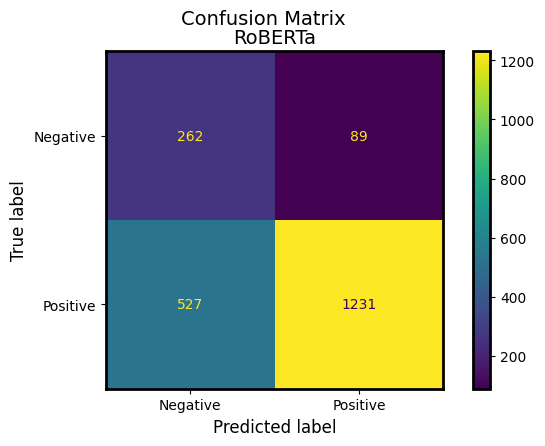

In [13]:
# Select best model for confusion matrix
best_id = 2
best_m = 'sentiment_' + models[best_id]['col_suffix'] + '_cat'

# Similar filtering to above
if 'neutral' in train_01_df[best_m].unique():
    filtered_df = train_01_df
else:
    filtered_df = train_01_df[train_01_df['TRUE_SENTIMENT'] != 'neutral']

# Get unique labels for best graphic
dlabels = np.unique(filtered_df[best_m].unique())

# Plot confusion matrix
fig, ax = plt.subplots()

cmd = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(
    filtered_df['TRUE_SENTIMENT'], filtered_df[best_m]), display_labels=[s.capitalize() for s in dlabels])
cmd.plot(ax = ax)

plt.suptitle('Confusion Matrix', y = 1)
plt.title(models[best_id]['name'])
plt.show()

## Sentiment Analysis: EDA Extended

In [14]:
# Set dataframe copy for SA model run(s)
news_05_df = news_04_df.copy()
news_05_df['processed_text'].fillna('neutral', inplace=True)

# Iterate through selected models
for i, model in enumerate(models):
    # Optionally only run the best model
#    if i != best_id:
#        continue

    c_labels = 'sentiment_' + model['col_suffix'] + '_cat'
    c_probs = 'sentiment_' + model['col_suffix'] + '_prob'
    c_scores = 'sentiment_' + model['col_suffix']

    # Run model
    news_05_df[c_labels], news_05_df[c_probs], news_05_df[c_scores], elapsed =\
        run_model(model['hf_model'], news_05_df, 'processed_text', device)

# Persist dataframe with sentiments (so don't need to re-run)
print(f'Writing={len(news_05_df)}')

sentiment_cols = [col for col in news_05_df.columns if col.startswith('sentiment_')]
cols_to_keep = ['text_id'] + sentiment_cols
news_05_df[cols_to_keep].to_csv('../data/news-05.csv', index=False)

print(f'Written={len(news_05_df)}')

Processing distilbert-base-uncased-finetuned-sst-2-english


  0%|          | 10/2276 [00:01<05:04,  7.44it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2276/2276 [05:31<00:00,  6.87it/s]


Processing bert-base-uncased


  0%|          | 10/2276 [00:02<07:54,  4.78it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2276/2276 [08:24<00:00,  4.51it/s]


Processing siebert/sentiment-roberta-large-english


  0%|          | 10/2276 [00:05<21:36,  1.75it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2276/2276 [22:06<00:00,  1.72it/s]


Processing cardiffnlp/twitter-roberta-base-sentiment


  0%|          | 10/2276 [00:02<07:58,  4.73it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 2276/2276 [08:27<00:00,  4.48it/s]


Writing=36405
Written=36405
